In [6]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from scipy import stats

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración matplotlib
# ==============================================================================
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Varios
# ==============================================================================
from tqdm import tqdm

In [17]:
day_one = [138, 130, 135, 140, 120, 125, 120, 130, 130, 144, 143, 140, 130, 150]
day_two = [116, 120, 125, 110, 120, 135, 124, 118, 120, 130, 140, 140, 130, 138]

datos = {
    'day_one': day_one,
    'day_two': day_two
}

datos = pd.DataFrame(data=datos)
datos.info()
np.corrcoef(day_one, day_two)[0][1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   day_one  14 non-null     int64
 1   day_two  14 non-null     int64
dtypes: int64(2)
memory usage: 352.0 bytes


0.35703170627566405

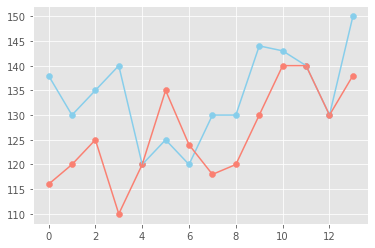

In [27]:
# Gráficos distribución observada
# ==============================================================================
plt.scatter(x=list(range(datos.day_one.size)), y=datos.day_one, c='skyblue')
plt.plot(list(range(datos.day_one.size)), datos.day_one, c='skyblue')

plt.scatter(x=list(range(datos.day_two.size)), y=datos.day_two, c='salmon')
plt.plot(list(range(datos.day_two.size)), datos.day_two, c='salmon')
plt.show()

In [19]:
r, p = stats.pearsonr(datos.day_one, datos.day_two)

print(round(r, 4))
print(round(p, 4))

0.357
0.2102


In [20]:
corr_df = pd.DataFrame(columns=['r', 'p'])

for col in datos:
    print(col)
    if pd.api.types.is_numeric_dtype(datos[col]) and col != 'day_one':
        r, p = stats.pearsonr(datos.day_one, datos[col])
        corr_df.loc[col] = [round(r, 3), round(p, 3)] 
    
corr_df

day_one
day_two


,r,p
day_two,0.357,0.21


In [21]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.describe()

,day_one,day_two
count,14.000000,14.000000
mean,133.928571,126.142857
std,9.042330,9.534207
min,120.000000,110.000000
25%,130.000000,120.000000
50%,132.500000,124.500000
75%,140.000000,133.750000
max,150.000000,140.000000


In [28]:
def dif_mean(x1, x2):
    '''
    Función para calcular la diferencia de medias entre dos grupos.
    
    Parameters
    ----------
    x1 : numpy array
         valores de la muestra 1.
         
    x2 : numpy array
         valores de la muestra 2.
         
    Returns
    -------
    estadístico: float
        valor del estadístico.
    '''
    
    estadistico = np.mean(x1) - np.mean(x2)
    return(estadistico)

In [26]:
dif_observada = dif_mean(
                    x1 = datos.day_one,
                    x2 = datos.day_two
                )
print(f"Diferencia observada: {dif_observada}")

Diferencia observada: 7.785714285714278


In [27]:
def permutaciones(x1, x2, fun_estadistico, n_iteraciones=9999):
    '''
    Función para calcular el valor del estadístico en múltiples permutaciones
    de dos muestras.
    
    Parameters
    ----------
    x1 : numpy array
         valores de la muestra 1.
         
    x2 : numpy array
         valores de la muestra 2.
 
    fun_estadistico : function
        función que recibe como argumento las dos muestras y devuelve el valor
        del estadístico.
        
    n_iteraciones : int
        número de permutaciones calculadas (default `9999`).
        
    Returns
    -------
    distribuciones: numpy array
        valor del estadístico en cada permutación.
    '''
    
    n_x1 = len(x1)
    n_x2 = len(x2)
    pool_datos = np.hstack((x1, x2))
    
    resulados_permutaciones = np.full(shape=n_iteraciones, fill_value=np.nan)
    
    for i in tqdm(range(n_iteraciones)):
        np.random.shuffle(pool_datos)
        estadistico = fun_estadistico(pool_datos[:n_x1], pool_datos[n_x1:])
        resulados_permutaciones[i] = estadistico
        
    return resulados_permutaciones

In [29]:
dist_permut = permutaciones(
                x1 = datos.day_one,
                x2 = datos.day_two,
                fun_estadistico = dif_mean,
                n_iteraciones   = 9999
              )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 50627.48it/s]


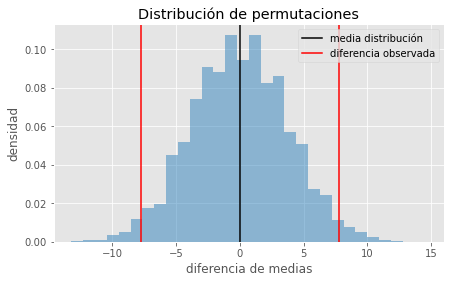

In [31]:
# Distribución de permutaciones
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_permut, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dist_permut.mean(), color='black', label='media distribución')
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=-dif_observada, color='red')

ax.set_title('Distribución de permutaciones')
ax.set_xlabel('diferencia de medias')
ax.set_ylabel('densidad')
ax.legend();

In [32]:
pd.Series(dist_permut).describe()

count    9999.000000
mean        0.029296
std         3.764691
min       -13.214286
25%        -2.500000
50%         0.071429
75%         2.642857
max        14.642857
dtype: float64

In [48]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_permut) > np.abs(dif_observada)))/len(dist_permut)
p_value_correc = (sum(np.abs(dist_permut) > np.abs(dif_observada)) + 1)/len(dist_permut + 1)
print(f"p-value sin corrección: {p_value}")
print(f"p-value con corrección: {p_value_correc}")

p-value sin corrección: 0.827982798279828
p-value con corrección: 0.828082808280828


In [34]:
def dif_var(x1, x2):
    '''
    Función para calcular la diferencia de varianzas entre dos muestras.
    
    Parameters
    ----------
    x1 : numpy array
         valores de la muestra 1.
         
    x2 : numpy array
         valores de la muestra 2.
         
    Returns
    -------
    estadístico: float
        valor del estadístico.
    '''
    
    estadistico = np.var(x1) - np.var(x2)
    return(estadistico)

In [36]:
dif_observada = dif_var(
                    x1 = datos.day_one,
                    x2 = datos.day_two
                )
print(f"Diferencia observada: {dif_observada}")

Diferencia observada: -8.484693877551024


In [39]:
dist_permut = permutaciones(
                x1 = datos.day_one,
                x2 = datos.day_two,
                fun_estadistico = dif_var,
                n_iteraciones   = 9999
              )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 21870.16it/s]


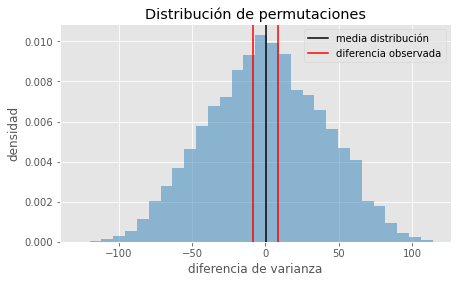

In [40]:
# Distribución de permutaciones
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_permut, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dist_permut.mean(), color='black', label='media distribución')
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=-dif_observada, color='red')

ax.set_title('Distribución de permutaciones')
ax.set_xlabel('diferencia de varianza')
ax.set_ylabel('densidad')
ax.legend()

In [41]:
pd.Series(dist_permut).describe()

count    9999.000000
mean        0.200165
std        39.297545
min      -127.872449
25%       -27.515306
50%         0.117347
75%        28.071429
max       114.005102
dtype: float64

In [49]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_permut) > np.abs(dif_observada)))/len(dist_permut)
p_value_correc = (sum(np.abs(dist_permut) > np.abs(dif_observada)) + 1)/len(dist_permut + 1)
print(f"p-value sin corrección: {p_value}")
print(f"p-value con corrección: {p_value_correc}")

p-value sin corrección: 0.827982798279828
p-value con corrección: 0.828082808280828
